In [193]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#from astropy.modeling import models, fitting
#from astropy.stats import sigma_clip
#import scipy.signal as sgn
#import pandas as pd
#df=pd.read_csv('Part II/-5_B7.5/F0000CH2.csv', sep=',', header = None)
#print(df)

In [194]:
I_sat=4.1 #mW/cm^2, Saturation Intensity taken from F20.pdf page 82
lw=2*np.pi*6.07 #MHz, Natural Line Width of RB 85 (what about 87?) taken from F20.pdf page 82
Trans=0.96 #a.u., Transmission of the optical viewport taken from F20.pdf page 83
radius=25.4 #mm, radius of the collecting lense taken from F20.pdf page 83
distance=150 #mm, distance between MOT and Photodiode taken from F20.pdf page 83
G=4.75e6 #V/A, Gain of Photdiode amplifier at +70dB taken from F20.pdf page 83
Gf=G*0.05 #V/A, Error of G taken from F20.pdf page 83
QE=0.52 #A/W, Quantum Efficiency of the sensor taken from F20.pdf page 83
QEf=0.015 #A/W, Error of QE taken from F20.pdf page 83
S=1e6/(1e6+50) #a.u., Scale Factor cause by impedance difference taken from F20.pdf page 83
sp_85=384.230406373e12 #Hz, S->P transition for RB85 taken from F20.pdf page 19
sf3_85=1.264888e9 #Hz, deltaF in S for F=3 for RB85 taken from F20.pdf page 19
pf2_85=83.835e6 #Hz, deltaF in P for F=2 for RB85 taken from F20.pdf page 19
pf4_85=100.205e6 #Hz, deltaF in P for F=4 for RB85 taken from F20.pdf page 19
planck=6.626e-34 #Js, Planck constant h
speed=2.99792458e8 #m/s, Speed of Light c
n=32 #amount of csv files
narr=np.arange(n+1,dtype=int) #array for loop
detuning=([5,6,7,8,10,12,14,16]) #array for indexing detuning
#arrays for current indexing current
current75=([0,4,8,12,16,20,24,29]) 
current8=([1,5,9,13,17,21,25,30])
current85=([2,6,10,14,18,22,27,31])
current9=([3,7,11,15,19,23,28,32])

In [195]:
#defining constant fit function for background noise
def con(x,b): 
    return 0*x+b

#defining scatteringRate for conversion
def scatteringRate(detuning):
    resultScatteringRate = (lw/2)*(I_r/I_sat)/(1+I_r/I_sat+4*detuning**2/lw**2)
    return resultScatteringRate

#defining wavelength with detuning for conversion
def wavelength(detuning):
    return speed/(sp_85-sf3_85+pf4_85-pf2_85-detuning)

#defining energy from a phton with wavelength(detuning) for conversion
def energy(detuning):
    energyCalc = planck*c/wavelength(detuning)
    return energyCalc

#defining solid angle theta for conversion
def theta():
    return radius**2/(4*distance**2)


In [196]:
#reading out the csv and returning time and voltage as arrays
def grabData(file):
    #file is string with form :
    #'Part II/-<absolute detuning value>_B<value of the current>/F<# of csv with 4 digits>CH1.csv'
    #for example 'Part II/-6_B7.5/F0001.csv'
    dg = np.genfromtxt(file, delimiter=',')
    #6 dim array with most of them being 'empty' caused by the way Oscilloscope writes the .csv
    #Example of the first 3 'lines', column 0 and 1 become NaN as well after 17 lines
#                   0                   1   2      3     4   5
#0        Record Length        2.500000e+03 NaN  0.000  3.04 NaN
#1      Sample Interval        1.000000e-03 NaN  0.001  3.02 NaN
#2        Trigger Point  0.000000000000e+00 NaN  0.002  3.02 NaN
    g0,g1,g2,g3,g4,g5 = np.hsplit(dg,6)
    #g3=time, g4=voltage
    return g3,g4

#translating voltage into #atoms
def conversion(voltage,detuning):
    natoms = voltage/(QE*G*S*T*theta*scatteringRate(detuning)*Energy(detuning))
    return natoms

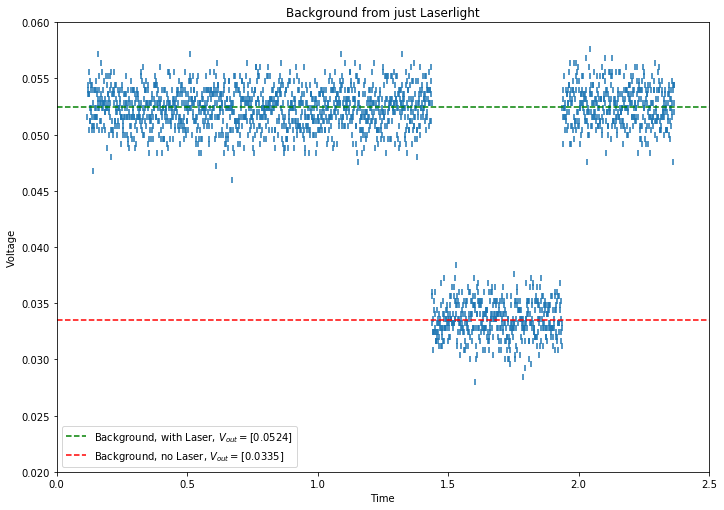

In [222]:
#Determinging the Background being measured by the ccd with and without laser
t0b, background = grabData('Part II/Background/F0033CH1.csv') #change folder 'Part II if needed'

t1b = t0b[np.where(background > 0.025)]
back = background[np.where(background > 0.025)]

xbb = t0b[np.where(background > 0.043)]
ybb = background[np.where(background > 0.043)]
ubb, fbb = curve_fit(con,xbb,ybb)
#ubb = background with laser (ubackgroundbright) in V

xb = t0b[np.where(background < 0.043)]
yb = background[np.where(background < 0.043)]
xbd = xb[np.where(yb > 0.025)]
ybd = yb[np.where(yb > 0.025)]
ubd, fbd = curve_fit(con,xbd,ybd)
#ubd = background without laser (ubackgrounddark) in V

xlin=np.arange(4)
plt.scatter(t1b,back,marker="|")
plt.plot(xlin,con(xlin,ubb),'green',linestyle='--',
        label='Background, with Laser, $V_{out}=$'+str(np.round(ubb,4)))
plt.plot(xlin,con(xlin,ubd),'red',linestyle='--',
         label='Background, no Laser, $V_{out}=$'+str(np.round(ubd,4)))

plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend(loc='lower left')
plt.xlim(0,2.5)
plt.ylim(0.02,0.06)
plt.title('Background from just Laserlight')
plt.gcf().set_size_inches(11.69, 8.27)
plt.show()

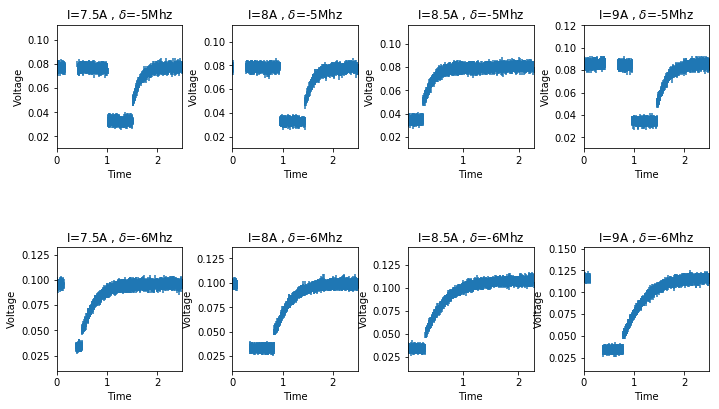

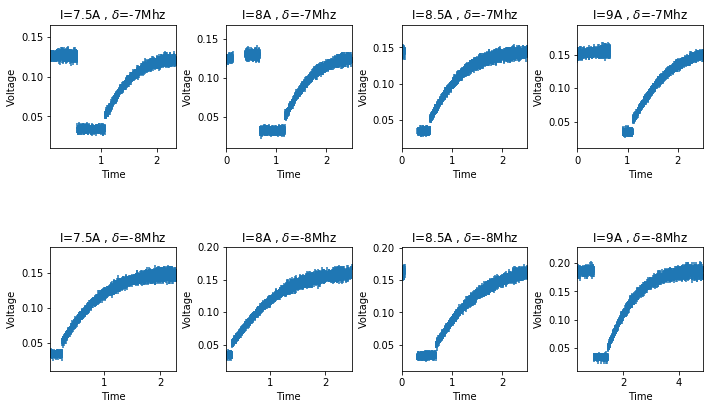

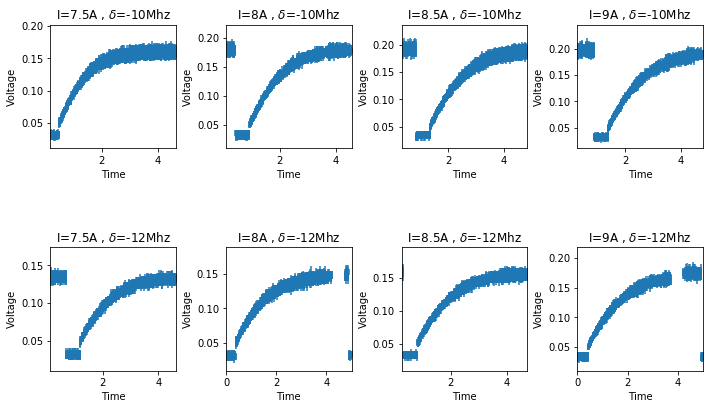

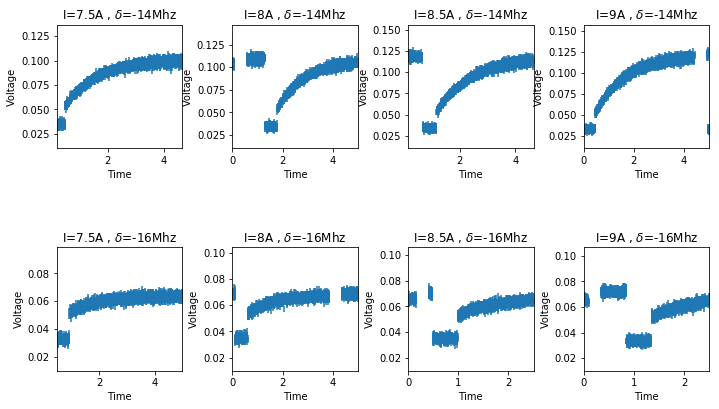

In [225]:
#Reading out all 33 Files, we skip one file so we end up with 32
#create empty array that we fill, when called it gives back data according to: 
#array[file index(0-31),value(0-2499),specify(0-2)] specify: 0=detuning[MHz], 1=current[A], 2=value
t_all = np.empty((n,2500,3))
u_all = np.empty((n,2500,3))
for i in narr: 
    if(i==0): j=1
    if(i==26): continue #removed cause we have this data set 2 times and this one was worse
    #building the string to read next file 
    #part I: F<4 digits number of .csv starts at 0000>
    if(i<10):
        c='F000'+str(i)
    else:
        c='F00'+str(i)
    #part II: <value of current> and adding counter for current for array
    if(i in current75):
        b='7.5'
        r=7.5
    if(i in current8):
        b='8'
        r=8
    if(i in current85):
        b='8.5'
        r=8.5
    if(i in current9):
        b='9'
        r=9
    #part III: <abolsute detuning value> and adding counter for detuning for array
    if(i<4):
        a=str(5)
        z=detuning[0]
    elif(i<8):
        a=str(6)
        z=detuning[1]
    elif(i<12):
        a=str(7)
        z=detuning[2]
    elif(i<16):
        a=str(8)
        z=detuning[3]
    elif(i<20):
        a=str(10)
        z=detuning[4]
    elif(i<24):
        a=str(12)
        z=detuning[5]
    elif(i<29):
        a=str(14)
        z=detuning[6]
    else:
        a=str(16)
        z=detuning[7]
    #patching together the actual path
    path = 'Part II/-'+a+'_B'+b+'/'+c+'CH1.csv' 
    t,u = grabData(path)
    #everything up till here was just to read out the .csv
    #filling the arrays with i==26 exception rule
    if(i<26):
        u_all[i,:]=u
        u_all[i,:,1]=r
        u_all[i,:,0]=z
        t_all[i,:]=t
        t_all[i,:,1]=r
        t_all[i,:,0]=z
    else:
        u_all[i-1,]=u 
        u_all[i-1,:,1]=r
        u_all[i-1,:,0]=z
        t_all[i-1,:]=t
        t_all[i-1,:,1]=r
        t_all[i-1,:,0]=z
    #drawing the subplots of just data while leaving "error" signals below 0.025V out 
    t = t[np.where(u > 0.025)]
    u = u[np.where(u > 0.025)] 
    plt.subplot(2,4,j)
    plt.scatter(t,u,marker="|") 
    plt.xlim(t[0],t[-1])
    ymax=np.amax(u)+0.03
    plt.ylim(0.01,ymax)
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title('I='+b+'A , $\delta$=-'+a+'Mhz')
    #every 8 subplots = 1 picture
    j=j+1
    if(j>8): 
        plt.subplots_adjust(wspace=0.4,hspace=0.8)
        plt.gcf().set_size_inches(11.69, 8.27/1.3)
        plt.show()
        j=1
    #clean up    
    del t,u,z,r,a,b,c,path

In [192]:
np.shape(t_all)
print(t_all[0,:,0])

[5. 5. 5. ... 5. 5. 5.]


In [219]:
?plt.legend